# Chapter 4: Basics of Neural Networks

In [43]:
import numpy as np
import torch 
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline 

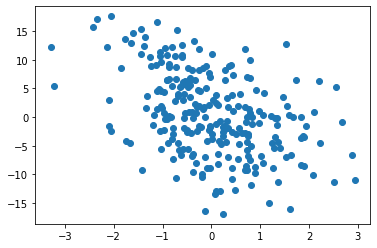

In [44]:
data = np.random.multivariate_normal([0,0],[[1,-3],[-3,52]],250)
X = torch.tensor(data[:,0]).type(torch.FloatTensor)
y = torch.tensor(data[:,1]).type(torch.FloatTensor)
plt.scatter(X,y)


## Linear model

We will focus on a linear model of the form $y = w_0 + w_1x + \epsilon$. Where $\epsilon$ is assumed to be gaussian noise with zero mean and variance $\sigma^2$.


**Analytic solution**

w: tensor([ 0.5505, -2.9698])


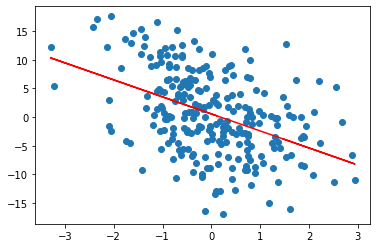

In [45]:
X_ = torch.cat((torch.ones(X.size()).unsqueeze(dim=1),X.unsqueeze(dim=1)),1)
w = torch.inverse(X_.T @ X_) @ X_.T @ y
print('w:',w)
plt.plot(X, X_ @ w,'r')
plt.scatter(X,y)

### Gradient descent
**Gradient descent with pytorch autograd**

In [46]:
def r_emp(w,X,y):
     return (y - X @ w).T @ (y - X @ w)

In [47]:
def min_r_emp_1(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1],requires_grad=True)
    
    for i in range(k):
        if w.grad is not None:
            w.grad.zero_()
        l_p = r_emp(w,X,y)
        l_p.backward()
        w = (w - lr*w.grad).detach().requires_grad_()
    return w

In [48]:
w_g = min_r_emp_1(X_,y)
print('Solution: ',w_g)

Solution:  tensor([ 0.5505, -2.9698], requires_grad=True)


**Gradient descent with pytorch autograd and optimizer**

In [49]:
def min_r_emp_2(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1],requires_grad=True)
    optimizer = optim.SGD([w],lr=lr)
    
    for i in range(k):
        l_p = r_emp(w,X,y)
        optimizer.zero_grad()
        l_p.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l_p))
    return w

In [50]:
w_g_2 = min_r_emp_2(X_,y,lr=0.001,k=500)
print('Solution:',w_g_2)

Epoch 0, Loss 15018.482422
Epoch 100, Loss 10450.375000
Epoch 200, Loss 10450.375000
Epoch 300, Loss 10450.375000
Epoch 400, Loss 10450.375000
Solution: tensor([ 0.5505, -2.9698], requires_grad=True)


**Gradient descent with manual differentiation**

In [51]:
def dw_r_emp(w,X,y):
    return X.T @ (X @ w - y)

In [52]:
def min_r_emp_3(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1])
    
    for i in range(k):
        l_p = r_emp(w,X,y)
        dw = dw_r_emp(w,X,y)
        w = (w - lr*dw)
    return w

In [53]:
w_g_3 = min_r_emp_3(X_,y,lr=0.001,k=500)
print('Solution:',w_g_3)

Solution: tensor([ 0.5505, -2.9698])


Define a general training loop

In [54]:
def training_loop(X,y,w,optimizer,model,loss_fn,lr=1e-3,n_epochs=5000):
   
    for i in range(n_epochs):
        y_p = model(w,X)
        loss = loss_fn(y_p,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print('Epoch %d, Loss %f' % (i,loss))

    print('Result:',w)
    return w

In [55]:
def model(w,X):
    return X @ w

def loss_fn(y_p,y):
    return 0.5*((y_p - y)**2).sum()

In [56]:
w = torch.ones(X_.shape[1],requires_grad=True)
optimizer = optim.SGD([w],lr=1e-3)

training_loop(X_,y,w,optimizer,model,nn.MSELoss())

Epoch 0, Loss 60.073929
Epoch 500, Loss 43.648148
Epoch 1000, Loss 41.988823
Epoch 1500, Loss 41.820599
Epoch 2000, Loss 41.803459
Epoch 2500, Loss 41.801708
Epoch 3000, Loss 41.801525
Epoch 3500, Loss 41.801502
Epoch 4000, Loss 41.801502
Epoch 4500, Loss 41.801498
Result: tensor([ 0.5505, -2.9698], requires_grad=True)


tensor([ 0.5505, -2.9698], requires_grad=True)

## Linear neuron with activation

### Sigmoid

generate 2-D testdata

C:\Users\dohr\AppData\Local\Temp\ipykernel_7568\4048414768.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)


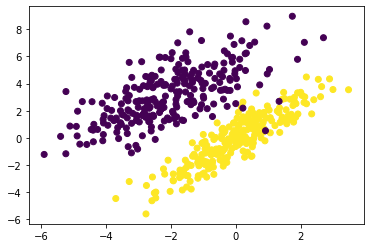

In [125]:
X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)
X2 = torch.tensor(np.random.multivariate_normal([-2,3],[[2,2],[2,4]],250)).type(torch.FloatTensor)
X = torch.cat((X1,X2),0)
y = torch.cat((torch.ones(250),torch.zeros(250)),0)

plt.scatter(X[:,0],X[:,1],c=y)

In [126]:
def model_sigmoid(X,w,bias=True):
    x_temp = torch.cat((torch.ones(X.shape[0]).unsqueeze(dim=1),X),dim=1)
    return torch.sigmoid(x_temp @ w)

In [127]:
def loss_sigmoid(y_p,y):
    r = -torch.log(y_p)*y - (1-y)*torch.log(1-y_p)
    return r.sum()

In [128]:
def train_loop_sigmdoid(X,y,lr=1e-4,n_epoch=500):
    w = torch.ones(3,requires_grad=True)
   # print(w)
    for i in range(n_epoch):
        if w.grad is not None:
            w.grad.zero_()

        y_p = model_sigmoid(X,w)
        l = loss_sigmoid(y_p,y)
        l.backward()

        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        w = (w - lr * w.grad)
        w.detach_()
        w.requires_grad_()

    return w

In [129]:
w = train_loop_sigmdoid(X,y,lr=1e-3,n_epoch=500)

Epoch 0, Loss 937.020630
Epoch 100, Loss 34.312016
Epoch 200, Loss 27.095751
Epoch 300, Loss 24.451456
Epoch 400, Loss 23.113468


In [140]:
y_p = model_sigmoid(X,w).detach()


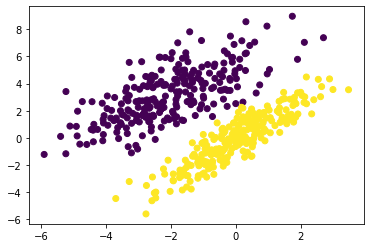

In [138]:
y_p[y_p < 0.5] = 0
y_p[y_p >= 0.5] = 1
plt.scatter(X[:,0],X[:,1],c=y_p)

### Sigmoid with cross entropy loss from pytorch

In [156]:
def train_loop_sigmdoid_2(X,y,loss_fn,lr=1e-3,n_epoch=500):
    w = torch.ones(3,requires_grad=True)
   # print(w)
    for i in range(n_epoch):
        if w.grad is not None:
            w.grad.zero_()

        y_p = model_sigmoid(X,w)
        l = loss_fn(y_p,y)
        l.backward()

        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        w = (w - lr * w.grad)
        w.detach_()
        w.requires_grad_()

    return w

In [164]:
loss_bce = nn.BCELoss(reduction='sum')
w = train_loop_sigmdoid_2(X,y,loss_bce,lr=1e-4,n_epoch=5000)
y_p = model_sigmoid(X,w).detach()

Epoch 0, Loss 937.020630
Epoch 100, Loss 85.063545
Epoch 200, Loss 67.875488
Epoch 300, Loss 57.717396
Epoch 400, Loss 51.004410
Epoch 500, Loss 46.245266
Epoch 600, Loss 42.697380
Epoch 700, Loss 39.951195
Epoch 800, Loss 37.762867
Epoch 900, Loss 35.978317
Epoch 1000, Loss 34.495457
Epoch 1100, Loss 33.243931
Epoch 1200, Loss 32.173775
Epoch 1300, Loss 31.248415
Epoch 1400, Loss 30.440563
Epoch 1500, Loss 29.729340
Epoch 1600, Loss 29.098579
Epoch 1700, Loss 28.535547
Epoch 1800, Loss 28.030018
Epoch 1900, Loss 27.573784
Epoch 2000, Loss 27.160099
Epoch 2100, Loss 26.783390
Epoch 2200, Loss 26.439030
Epoch 2300, Loss 26.123117
Epoch 2400, Loss 25.832386
Epoch 2500, Loss 25.564030
Epoch 2600, Loss 25.315643
Epoch 2700, Loss 25.085117
Epoch 2800, Loss 24.870708
Epoch 2900, Loss 24.670834
Epoch 3000, Loss 24.484127
Epoch 3100, Loss 24.309376
Epoch 3200, Loss 24.145504
Epoch 3300, Loss 23.991613
Epoch 3400, Loss 23.846844
Epoch 3500, Loss 23.710442
Epoch 3600, Loss 23.581764
Epoch 3700, 

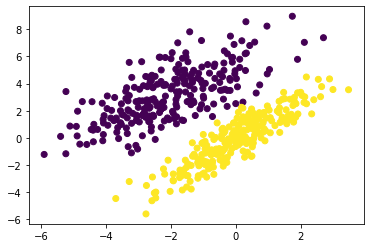

In [165]:
y_p[y_p < 0.5] = 0
y_p[y_p >= 0.5] = 1
plt.scatter(X[:,0],X[:,1],c=y_p)

### Softmax classification

generate testdata

C:\Users\dohr\AppData\Local\Temp\ipykernel_7568\3254666763.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)


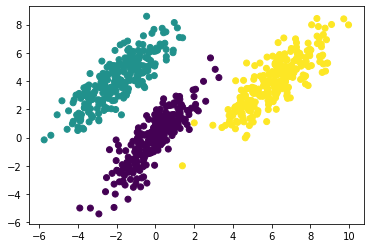

In [288]:
X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)
X2 = torch.tensor(np.random.multivariate_normal([-2,4],[[2,2],[2,3]],250)).type(torch.FloatTensor)
X3 = torch.tensor(np.random.multivariate_normal([6,4],[[2,2],[2,3]],250)).type(torch.FloatTensor)
X = torch.cat((X1,X2,X3),0)
y = torch.cat((torch.zeros(250),torch.ones(250),torch.ones(250)*2),0)

plt.scatter(X[:,0],X[:,1],c=y)

In [316]:
def model_softmax(X,w,bias=True):
    x_temp = torch.cat((torch.ones(X.shape[0]).unsqueeze(dim=1),X),dim=1)
    return torch.softmax(x_temp @ w.T,dim = 1)

def train_loop_softmax(X,y,optimizer, loss_fn,n_epoch=500):
#    w = torch.randn(3,3,requires_grad=True)

    for i in range(n_epoch):
        optimizer.zero_grad()

        w = optimizer.param_groups[0]['params'][0]

        y_p = model_softmax(X,w)
        l = loss_fn(y_p,y)
        l.backward()

        if i % 500 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        optimizer.step()
    return w

In [317]:
y_one_hot = nn.functional.one_hot(y.type(torch.LongTensor),num_classes=3)
y_one_hot = y_one_hot.type(torch.FloatTensor)
loss_ce = nn.CrossEntropyLoss(reduction='sum')
w = torch.randn(3,3,requires_grad=True)
optimizer = optim.SGD([w],lr=1e-3)

In [323]:
w = train_loop_softmax(X,y_one_hot,optimizer,loss_ce,n_epoch=5000)


Epoch 0, Loss 414.718170
Epoch 500, Loss 414.716370
Epoch 1000, Loss 414.714539
Epoch 1500, Loss 414.712769
Epoch 2000, Loss 414.711121
Epoch 2500, Loss 414.709381
Epoch 3000, Loss 414.707703
Epoch 3500, Loss 414.706055
Epoch 4000, Loss 414.704437
Epoch 4500, Loss 414.702881


In [324]:
y_p = model_softmax(X,w)
y_c = y_p.argmax(dim=1)

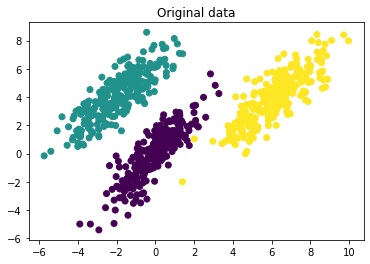

In [329]:
plt.title('Original data')
plt.scatter(X[:,0],X[:,1],c=y)

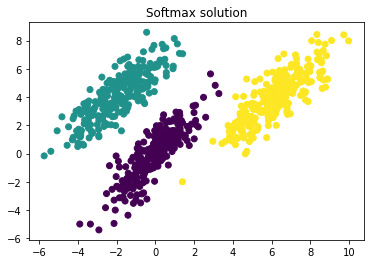

In [328]:
plt.title('Softmax solution')
plt.scatter(X[:,0],X[:,1],c=y_c)

### Example: aproximate sin(x)

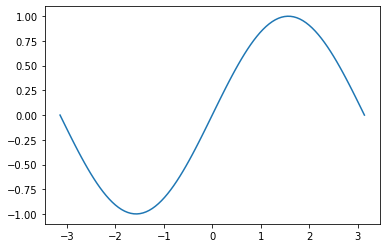

In [331]:
x = torch.linspace(-torch.pi,torch.pi,steps=100)
y = torch.sin(x)
plt.plot(x,y)

In [430]:
def train_loop_seq(X,y,model,optimizer, loss_fn,n_epoch=5000):
#    w = torch.randn(3,3,requires_grad=True)

    step = int(n_epoch/10)
    for i in range(n_epoch):
        optimizer.zero_grad()


        y_p = model(X)
        l = loss_fn(y_p,y)
        l.backward()

        if i % step == 0:
            print('Epoch %d, Loss %f' % (i,l))

        optimizer.step()
    print('training loop finished')


In [428]:
seq_model = nn.Sequential(
    nn.Linear(1,1250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250,1250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250,1),)
x_t = x.unsqueeze(dim=1)
x_t.requires_grad_()
y_t = y.unsqueeze(dim=1)
optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
loss_mse = nn.MSELoss()

In [429]:
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=5000)

Epoch 0, Loss 0.281048
Epoch 500, Loss 0.001014
Epoch 1000, Loss 0.000246
Epoch 1500, Loss 0.000104
Epoch 2000, Loss 0.000056
Epoch 2500, Loss 0.000035
Epoch 3000, Loss 0.000024
Epoch 3500, Loss 0.000018
Epoch 4000, Loss 0.000014
Epoch 4500, Loss 0.000011


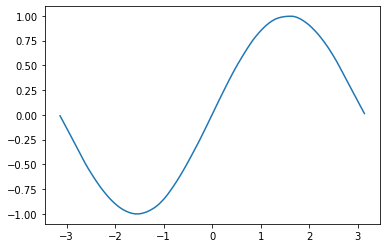

In [431]:
y_p = seq_model(x_t)
y_p.detach_()
y_p.squeeze_()
plt.plot(x,y_p)